In [1]:
# | default_exp buffer_of_thought


The "Buffer of Thoughts" (BoT)[@yang2024bufferthoughtsthoughtaugmentedreasoning] is a framework designed to enhance the **accuracy**, **efficiency**, and **robustness** of Large Language Models (LLMs) in reasoning tasks.

## **Key Features of BoT**
1. **Long-Term Memory** 
    BoT introduces a **meta-buffer**, which serves as a kind of long-term memory, persisting across different sessions. This repository stores high-level **thought-templates** distilled from prior problem-solving processes. These templates are retrieved and adapted for diverse tasks, eliminating the need to design reasoning structures anew.
2. **Three Components**
    - **Problem Distiller**: Responsible for extracting key information and constraints from tasks.
    - **Meta-Buffer**: A lightweight memory storing thought-templates, which can span across various categories and domains. While six categories are mentioned in the paper (e.g., text comprehension, mathematical reasoning), the framework is not inherently restricted to this classification or number.
    - **Buffer Manager**: Dynamically updates the meta-buffer by distilling new templates as tasks are solved, ensuring the memory evolves with experience.
3. **Advantages**
    - **Improved Accuracy**: By adapting templates to different tasks, BoT achieves precise and reliable reasoning.
    - **Efficiency**: Stored templates allow LLMs to bypass complex multi-query reasoning, streamlining the process.
    - **Robustness**: The generalized reasoning framework ensures consistent performance across a variety of tasks.

## Notebook Objective
- Demonstrates the implementation of BoT using **LangGraph**, highlighting long-term memory capabilities via a `BaseStore` object for persistent storage and retrieval of thought-templates.  
- Showcases LangGraph's support for dynamic and adaptive memory, enhancing LLMs' reasoning capabilities within the BoT framework.  

![Illustration of the BoT Method. Figure taken from [@yang2024bufferthoughtsthoughtaugmentedreasoning]](bot_agent.png)

## Setup

In [2]:
# | exports

from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal, Optional
import textwrap
import os
from trustcall import create_extractor
from pathlib import Path
import uuid
from langchain.embeddings import init_embeddings
from agentic.utils import *

## Prompts

We start by writing down the relevant prompts for each of the three components. They are copy-pasted from the original publication.

In [3]:
# | exports

problem_distiller_prompt = textwrap.dedent(
    """
    ## Problem Distiller

    You are a highly professional and intelligent expert in information distillation. Your role is to extract essential information from user input queries to solve problems effectively. You also transform this extracted information into a suitable format based on the type of issue.

    ---

    ### Task Instructions

    1. **Key Information**:
    - Extract values and key variables from the user input.
    - Ensure all essential information required to solve the problem is provided.
    - Hand over this distilled information to the respective expert for task resolution.

    2. **Restrictions**:
    - Identify the objective of the problem.
    - Outline any corresponding constraints that must be adhered to.

    3. **Distilled Task**:
    - Extend the problem based on the extracted key information and constraints.
    - Summarize a meta problem that addresses the user query and accommodates more input and output variations.
    - Incorporate the real-world scenario of the extended problem.
    - Define types of key variables and information constraints from the original problem to restrict variables in the extended problem.
    - Use the input key information from the user query as an example to solve the problem.
    """
).strip()

The Instantiate Reasoning step is part of the Meta-Buffer and adapts thought-templates to solve specific tasks. It either instantiates a retrieved template with task-specific reasoning structures or assigns a general template for new tasks, ensuring efficient and accurate problem-solving.

In [4]:
# | exports

instantiate_reasoning_prompt = textwrap.dedent(
    """
    ## Meta Reasoner

    You are a Meta Reasoner who is extremely knowledgeable in various fields, including Computer Science, Math, Physics, Literature, History, Chemistry, Logical Reasoning, Culture, and Language. You are also skilled in applying high-level reasoning structures for different tasks. 

    ### Reasoning Structures:

    1. **Prompt-based Structure**:
    - **Best For**: Common Sense Reasoning, Application Scheduling.
    
    2. **Procedure-based Structure**:
    - **Best For**: Creative tasks like Creative Language Generation, and Text Comprehension.
    
    3. **Programming-based Structure**:
    - **Best For**: Mathematical Reasoning, Code Programming.
    - Can transform real-world problems into programming problems to solve efficiently.

    ---

    ### Reasoning Instantiation

    **Your Task:**

    1. **Contextual Analysis**: Deliberately consider the context and the problem distilled from the problem distiller. Use your understanding to identify a suitable domain expert for solving the problem.

    2. **Structure Selection**: Based on the distilled information, select one of the reasoning structures suitable for addressing the problem.

    3. **Template Application**: If a thought-template is provided, directly follow it to instantiate the solution for the given problem.
    """
).strip()

The following prompts outline the behavior of the Buffer Manager and the process for creating a new template when no suitable template is found during the Meta-Buffer’s template retrieval step. This process, known as *Template Distillation*, involves two key steps: first, summarizing the task using the distilled task description and the derived solution; second, leveraging this summary to perform a contextual search for in-task and cross-task examples, which are then used as few-shot examples to generate the new template.

In [5]:
# | exports

# prompt to infer the core task summary. That one is needed for contextual search for relevant in-task and cross-task templates as few-shot examples for generating the
core_task_summarization_prompt = textwrap.dedent(
    """
    ## Prompt for Template Distillation:

    **User Input**:
    **Problem Description**: {distilled_task}
    **Solution Steps or Code**: {solution_steps}

    1. **Core task summarization**:
        Identify and describe the basic type and core challenges of the problem, such as classifying it as a mathematical problem (e.g., solving a quadratic equation), a data structure problem (e.g., array sorting), an algorithm problem (e.g., search algorithms), etc. And analyze the most efficient way to solve the problem.
    """
).strip()


template_distiller_prompt = textwrap.dedent(
    """
    ## Prompt for Template Distillation (continued)

    2. **Solution Steps Description**:
    Outline the general solution steps, including how to define the problem, determine variables, list key equations or constraints, choose appropriate solving strategies and methods, and how to verify the correctness of the results.

    3. **General Answer Template**:
    Based on the above analysis, propose a template or approach that can be widely applied to this type of problem, including possible variables, functions, class definitions, etc. If it is a programming problem, provide a set of base classes and interfaces that can be used to construct solutions to specific problems.

    Please ensure that your response is highly concise and structured, so that specific solutions can be transformed into generalizable methods.

    [Optional] Here are some exemplars of the thought-template:

    <in-task-examples>
    {in_task_examples}
    <in-task-examples>

    <cross-task-examples>
    {cross_task_examples}
    <cross-task-examples>
    """
).strip()

Some prompts, provided to the [Trustcall Executors](https://github.com/hinthornw/trustcall) defined in the next section, are used to extract structured output from the plain text responses of the LLM.

In [6]:
# | exports

structure_prompt = textwrap.dedent(
    """
    Extract the items of the 'ThoughtTemplate' Pydantic class from the previous conversation.
                                    
    <convo>
    {conversation}
    </convo> 
    """
).strip()

distilled_task_extractor_prompt = textwrap.dedent(
    """
    Extract the content of the 'Extended Problem' subsection within the 'Distilled Task' section from the entire distilled problem description.

    <distilled-problem>
    {distilled_problem}
    <distilled-problem>
    """
).strip()

## Templates

A Pydantic class is used to digest and extract Thought Templates in the required format. It consists of three sections: a "Task Description" which provides a brief overview of the task; a "Solution Description" which outlines a high-level approach to solving the task; and finally, the "Thought Template" itself, which offers a step-by-step guide for solving the problem.

In [7]:
# | exports


class ThoughtTemplate(BaseModel):
    """Defining the three fields of the Thought Template"""

    task_description: str = Field(description="Task Description")
    solution_description: str = Field(description="Solution Description")
    thought_template: str = Field(description="Thought Template")

## Runnables

The [Lang-Chain Runnables](https://python.langchain.com/docs/concepts/runnables/) encapsulating the main logic of the subsequently defined nodes of the graph.

In [8]:
# | exports

# Setup Large Language Model (LLM)
LLM = ChatOpenAI(
    model_name="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.0,
)

In [9]:
# | exports

# Define Trustcall instance for sane extraction of the Thought Template items: Task Description, Solution Description, Thought Template
structure_template_text = create_extractor(
    LLM, tools=[ThoughtTemplate], tool_choice="ThoughtTemplate"
)

# Extract the distilled task from the distilled problem. Required for the semantic search in the Template retrieval step.
distilled_task_extractor = (
    PromptTemplate.from_template(
        template=distilled_task_extractor_prompt) | LLM
)

## Long-Term Memory

All Thought Templates are stored in a Long-Term Memory to ensure their availability across sessions. The Long-Term Memory supports semantic search on the Task Description of each Thought Template, which plays a crucial role in two steps: first, during template retrieval in the Meta-Buffer, where a relevant template is identified for the problem; and second, during Template Distillation by the Buffer Manager, where it is used to retrieve relevant in-task and cross-task few-shot examples for generating a new template.

In [10]:
# | exports

# Create store with semantic search enabled
template_store = InMemoryStore(
    index={
        "embed": init_embeddings(model="openai:text-embedding-3-small"),
        "dims": 1536,
        "fields": ["task_description"],
    }
)

/var/folders/9y/v7607j0j5vn1tnw1_fjpl4s40000gn/T/ipykernel_57334/1635323190.py:6: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  "embed": init_embeddings(model="openai:text-embedding-3-small"),


Optionally, one can populate the Thought Template storage with predefined templates like the six ones listed in the appendix of [@yang2024bufferthoughtsthoughtaugmentedreasoning] or one can also start with a blank template store.

In [11]:
# | exports

user_id = "user_123"
long_term_memory = "thought_templates"
namespace_for_memory = (user_id, long_term_memory)

populate = True
# Optional, we populate the memory with some templates
if populate:
    # Dynamically determine the notebook's directory
    notebook_dir = Path(
        __file__).parent if "__file__" in globals() else Path.cwd()

    # Define the path relative to the notebook's directory
    template_path = notebook_dir / "data" / long_term_memory

    # Ensure the directory exists before iterating
    if populate and template_path.exists():
        for md_fl in template_path.iterdir():
            template_name, _ = md_fl.name.split(".")
            with open(md_fl) as fl:
                template_store.put(
                    namespace_for_memory, template_name, markdown_to_json(
                        fl.read())
                )
    else:
        print(f"Template path '{template_path}' does not exist.")

## States

The state of the LangGraph agent is defined by inheriting from `MessageState`, the default state of LangGraph that stores the message history. Additionally, two more attributes are added, whose values are manipulated during the BoT agent's actions.

In [12]:
# | exports


class BoTState(MessagesState):
    # thought template possibly extracted from the long-term memory
    template_text: Optional[str]
    # part of the distilled problem description. Required for similarity computations
    distilled_task: str

## Nodes

Nodes of the LangGraph agent which update the state. Each Node maps onto each step of the BoT agent.

In [13]:
# | exports


def problem_distiller(state: BoTState) -> dict:
    """
    Distills task information from the forwarded problem description using a Language Model (LLM).

    This function represents the problem distillation step in the Buffer of Thoughts (BoT) framework.
    It processes the most recent message, which is the original problem description, in the agent's
    state to extract a distilled representation of the task and updates the state with the distilled task.

    Parameters
    ----------
    state : BoTState
        The current state of the agent, which contains the message history and other relevant attributes.

    Returns
    -------
    dict
        A dictionary with the following keys:
        - "distilled_task" : str
            The distilled task description extracted from the latest message which is the problem description.
        - "messages" : str
            The distilled problem description which contains the distilled task description but also a key information and problem constraints.
    """
    # Invoke the LLM with the problem distiller prompt and the latest message
    distilled_task = LLM.invoke(
        [problem_distiller_prompt, state["messages"][-1]])

    # Extract the distilled task description from the LLM response
    return {
        "distilled_task": distilled_task_extractor.invoke(
            distilled_task.content
        ).content,
        "messages": distilled_task,  # Update state with the distilled task message
    }

In [14]:
# | exports

def template_retrieval(
    state: BoTState, config: RunnableConfig, store: BaseStore
) -> dict:
    """
    Retrieves the most relevant thought template for a given task using semantic search.

    This function conducts a semantic search between the distilled task and the task descriptions
    of thought templates stored in the long-term memory. It selects the template with the highest
    similarity score if it exceeds a user-defined threshold. If no suitable template is found, the 
    template field is left blank.

    Parameters
    ----------
    state : BoTState
        The current state of the agent, containing the distilled task and other relevant information.
    config : RunnableConfig
        Configuration object containing user-defined parameters, including the retrieval threshold.
    store : BaseStore
        The long-term memory store where thought templates are stored and queried.

    Returns
    -------
    dict
        A dictionary with the following key:
        - "template_text" : str or None
            The text of the retrieved thought template if it satisfies the similarity threshold, 
            otherwise None.
    """
    # Perform semantic search between the distilled task and templates in long-term memory
    items = store.search(namespace_for_memory,
                         query=state["distilled_task"], limit=1)
    template = items.pop() if items else None

    # Check if the retrieved template exceeds the similarity threshold
    if template and template.score > config["configurable"]["retrieval_threshold"]:
        template_text = json_to_markdown(
            {
                key: val
                for key, val in template.value.items()
                if key != "task_description"
            }
        )
        return {"template_text": template_text}
    else:
        return {"template_text": None}

In [15]:
# | exports

def instantiate_reasoning(state: BoTState) -> dict:
    """
    Executes the main solution step for the BoT agent by attempting to solve the problem.

    This function represents the core reasoning process in the Buffer of Thoughts (BoT) framework.
    It uses either a retrieved thought template to guide the solution or, if no template is available, 
    applies a general solution approach as defined in the prompt.

    Parameters
    ----------
    state : BoTState
        The current state of the agent, containing the task description, thought template (if retrieved), 
        and other relevant information.

    Returns
    -------
    dict
        A dictionary with the following key:
        - "messages" : str
            The result of the reasoning step, either guided by the thought template or generated 
            using a general approach.
    """
    if state["template_text"]:
        # Reasoning step guided by the retrieved thought template
        return {
            "messages": LLM.invoke(
                [
                    state["messages"][-1],
                    (
                        "user",
                        instantiate_reasoning_prompt
                        + f"\n\n<thought-template>\n{state['template_text']}\n<thought-template>",
                    ),
                ]
            )
        }
    else:
        # Reasoning step using a general solution approach
        return {
            "messages": LLM.invoke(
                [state["messages"][-1], ("user", instantiate_reasoning_prompt)]
            )
        }

In [16]:
# | exports

def template_distillation(state: BoTState, config: RunnableConfig, store: BaseStore) -> dict:
    """
    Distills a new thought template when no suitable template is found in the long-term memory.

    This function is used when the Buffer of Thoughts (BoT) agent fails to retrieve a proper thought 
    template. It distills a new template by analyzing the task description and the derived solution. 
    Relevant in-task and cross-task examples (i.e., similar and diverse thought templates) are retrieved 
    from the long-term memory to guide the derivation of a new template.

    Parameters
    ----------
    state : BoTState
        The current state of the agent, containing the distilled task, derived solution, and other relevant details.
    config : RunnableConfig
        Configuration object containing user-defined parameters, including thresholds and limits for in-task 
        and cross-task template retrieval.
    store : BaseStore
        The long-term memory store where thought templates are stored and queried.

    Returns
    -------
    dict
        A dictionary containing:
        - "messages" : str
            The distilled thought template generated by the BoT agent, guided by the retrieved in-task 
            and cross-task examples.
    """
    # Summarize the core task and solution steps
    core_task_summarization_msg = core_task_summarization_prompt.format(
        distilled_task=state["distilled_task"],
        solution_steps=state["messages"][-1].content,
    )
    # Generate task summary using LLM
    task_summary = LLM.invoke(core_task_summarization_msg)

    # Search for relevant thought templates in the long-term memory
    items = store.search(
        namespace_for_memory,
        query=task_summary.content,
        limit=config["configurable"]["limit"],
    )

    # Separate templates into in-task and cross-task examples based on their similarity scores
    in_task_l = [
        template
        for template in items
        if template.score > config["configurable"]["in_task_threshold"]
    ]
    in_task = in_task_l.pop(0) if in_task_l else None

    cross_task_l = [
        template
        for template in items
        if template.score <= config["configurable"]["in_task_threshold"]
    ]
    cross_task = cross_task_l.pop(0) if cross_task_l else None

    # Use in-task and cross-task examples to guide the generation of a new thought template
    return {
        "messages": LLM.invoke(
            [
                ("user", core_task_summarization_msg),  # Task summarization
                task_summary,  # Task summary message
                (
                    "user",
                    template_distiller_prompt.format(
                        task_summary=task_summary,
                        in_task_examples=json_to_markdown(
                            in_task.value if in_task else {}
                        ),
                        cross_task_examples=json_to_markdown(
                            cross_task.value if cross_task else {}
                        ),
                    ),
                ),
            ]
        )
    }

In [17]:
# | exports

def dynamic_meta_buffer_update(
    state: BoTState, config: RunnableConfig, store: BaseStore
) -> dict:
    """
    Structures the distilled template into predefined sections and stores it in the Long-Term Memory.

    This function processes the distilled template by organizing it into three sections: 
    'Task Description', 'Solution Description', and 'Thought Template', as defined by the Pydantic class. 
    The structured template is then stored in the Long-Term Memory in JSON format.

    Parameters
    ----------
    state : BoTState
        The current state of the agent, containing the distilled template and related data.
    config : RunnableConfig
        Configuration object with user-defined parameters and metadata for storing the structured template.
    store : BaseStore
        The long-term memory store where the structured template is saved in JSON format.

    Returns
    -------
    dict
        A dictionary containing:
        - "messages" : str
            A message confirming the successful update of the Meta Buffer.
    """
    # Structure the distilled template into defined sections using the structure prompt
    result = structure_template_text.invoke(
        {
            "messages": [
                structure_prompt.format(
                    conversation=state["messages"][-1].content
                )
            ]
        }
    )

    # Extract the structured response and associated metadata
    r, rmeta = result["responses"].pop(), result["response_metadata"].pop()

    # Store the structured template in the Long-Term Memory
    store.put(
        (user_id, long_term_memory),  # Memory namespace and user context
        rmeta.get("json_doc_id", str(uuid.uuid4())),  # Unique document ID
        r.model_dump(mode="json"),  # Save structured template as JSON
    )

    # Return confirmation of Meta Buffer update
    return {"messages": "Meta Buffer updated"}

## Conditional Edges

In case a proper Thought Template was found during the Thought Template Retrieval step, we skip the distillation of a new template.

In [18]:
# | exports

def update_required(state: BoTState) -> Literal["Buffer Manager", "END"]:
    if state["template_text"]:
        return "END"
    else:
        return "Buffer Manager"

## Build the Graph

The graph representing the BoT agent consists of two sub-graphs: the Meta-Buffer and the Buffer-Manager. The Meta-Buffer handles the Template Retrieval and Reasoning Instantiation steps, while the Buffer-Manager generates a new Thought Template and updates the Long-Term Memory if the Template Retrieval step fails to find a matching template for the problem.

In [19]:
# | exports

meta_buffer = StateGraph(BoTState)

# add nodes
meta_buffer.add_node("Template Retrieval", template_retrieval)
meta_buffer.add_node("Instantiated Reasoning", instantiate_reasoning)

# add edges
meta_buffer.add_edge(START, "Template Retrieval")
meta_buffer.add_edge("Template Retrieval", "Instantiated Reasoning")
meta_buffer.add_edge("Instantiated Reasoning", END)

In [20]:
# | exports

buffer_manager = StateGraph(BoTState)

# add nodes
buffer_manager.add_node("Template Distillation", template_distillation)
buffer_manager.add_node("Dynamic Update", dynamic_meta_buffer_update)

# add edges
buffer_manager.add_edge(START, "Template Distillation")
buffer_manager.add_edge("Template Distillation", "Dynamic Update")
buffer_manager.add_edge("Dynamic Update", END)

In [21]:
# | exports

memory = MemorySaver()
bot_graph = StateGraph(BoTState)

# add nodes
bot_graph.add_node("Problem Distiller", problem_distiller)
bot_graph.add_node("Meta Buffer", meta_buffer.compile(checkpointer=memory))
bot_graph.add_node(
    "Buffer Manager", buffer_manager.compile(checkpointer=memory))

# add edges
bot_graph.add_edge(START, "Problem Distiller")
bot_graph.add_edge("Problem Distiller", "Meta Buffer")
bot_graph.add_conditional_edges(
    "Meta Buffer", update_required, {
        "Buffer Manager": "Buffer Manager", "END": END}
)
bot_graph.add_edge("Buffer Manager", END)

# compile graph
bot_agent = bot_graph.compile(checkpointer=memory, store=template_store)

In [22]:
# | hide
from IPython.display import Image, display

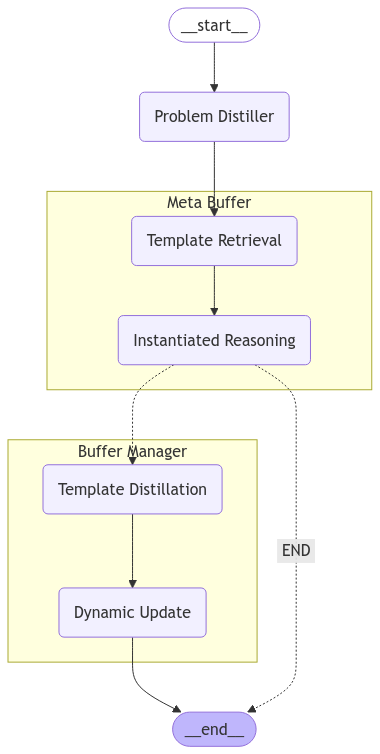

In [23]:
# View
display(Image(bot_agent.get_graph(xray=1).draw_mermaid_png()))

## Run the Agent

We run the agent for two different problems. The first one is sampled from the [Game of 24](https://github.com/princeton-nlp/tree-of-thought-llm)[@yao2023treethoughtsdeliberateproblem]. The second one is a word sorting problem which itself is part of the [BIG-Bench Hard (BBH)](https://github.com/google/BIG-bench) dataset.

In [24]:
# | hide

from agentic.download_bot_datasets import *

In [25]:
data = {"24-game": sample_from_datasets(1, Path("data"), "nlile", "24-game")}
data["word_sorting"] = sample_from_datasets(
    1, Path("data"), "maveriq/bigbenchhard", "word_sorting"
)

data

{'24-game': [{'numbers': [1, 1, 3, 10],
   'solutions': ['(10-1-1)×3'],
   'solvable': True,
   'amt': 9.04,
   'solved_rate': 0.884,
   'mean_time': 9.05,
   'std_time': 3.91}],
 'word_sorting': [{'input': "Sort the following words alphabetically: List: hangout drafty supposable sushi proscenium anticonvulsant you'd magnificent scrub embolden hasty pewee carrageen disseminate glamour discovery registrar acuity",
   'target': "acuity anticonvulsant carrageen discovery disseminate drafty embolden glamour hangout hasty magnificent pewee proscenium registrar scrub supposable sushi you'd"}]}

In [26]:
prompts = {}
prompts["24-game"] = [
    f"""
    Manipulate four numbers with basic arithmetic operations to reach 24.

    <numbers>
    {rec['numbers']}
    <numbers>
    """
    for rec in data["24-game"]
]
prompts["word_sorting"] = [rec["input"] for rec in data["word_sorting"]]

prompts

{'24-game': ['\n    Manipulate four numbers with basic arithmetic operations to reach 24.\n\n    <numbers>\n    [1, 1, 3, 10]\n    <numbers>\n    '],
 'word_sorting': ["Sort the following words alphabetically: List: hangout drafty supposable sushi proscenium anticonvulsant you'd magnificent scrub embolden hasty pewee carrageen disseminate glamour discovery registrar acuity"]}

In [27]:
config = RunnableConfig(
    max_concurrency=5,
    configurable={
        # ensuring a fresh run of the agent each time it is kicked off
        "thread_id": "24-game",
        "retrieval_threshold": 0.6,
        "in_task_threshold": 0.8,
        "limit": 100,
    },
)

# Run the agent by streaming the graph
for event in bot_agent.stream(
    input={"messages": prompts["24-game"][0]}, config=config, stream_mode="values"
):
    if event["messages"]:
        event["messages"][-1].pretty_print()

================================ Human Message =================================


    Manipulate four numbers with basic arithmetic operations to reach 24.

    <numbers>
    [1, 1, 3, 10]
    <numbers>
    
================================== Ai Message ==================================

### Key Information Extracted:
- **Objective**: Manipulate the numbers [1, 1, 3, 10] using basic arithmetic operations (addition, subtraction, multiplication, division) to reach the target number 24.
- **Key Variables**: 
  - Numbers: 1, 1, 3, 10
  - Target: 24
- **Operations Allowed**: Addition (+), Subtraction (-), Multiplication (*), Division (/)

### Constraints:
- Use each number exactly once.
- Only basic arithmetic operations are allowed.
- The result must equal 24.

### Distilled Task:
- **Extended Problem**: Given a set of four numbers, determine if it is possible to combine them using basic arithmetic operations to achieve a specified target number. This can be generalized to any set of fou

For the Game of 24 problem, the agent retrieves the Coding Thought Template and uses it to derive a Python program as a generic solution (caveat: the solution is printed in Polish notation).

In [28]:
state = bot_agent.get_state(config)
code = extract_python_blocks(state.values["messages"][-1].content).pop()
exec(code)

10 - 1 - 1 * 3


In [29]:
config["configurable"]["thread_id"] = "word_sorting"

# Run the agent by streaming the graph
for event in bot_agent.stream(
    input={"messages": prompts["word_sorting"][0]}, config=config, stream_mode="values"
):
    if event["messages"]:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Sort the following words alphabetically: List: hangout drafty supposable sushi proscenium anticonvulsant you'd magnificent scrub embolden hasty pewee carrageen disseminate glamour discovery registrar acuity
================================== Ai Message ==================================

### Key Information Extracted:
- **Objective**: Sort a list of words alphabetically.
- **Input List**: 
  - hangout
  - drafty
  - supposable
  - sushi
  - proscenium
  - anticonvulsant
  - you'd
  - magnificent
  - scrub
  - embolden
  - hasty
  - pewee
  - carrageen
  - disseminate
  - glamour
  - discovery
  - registrar
  - acuity

### Constraints:
- The sorting must be done in alphabetical order.

### Distilled Task:
- **Extended Problem**: Create a function that can sort any given list of words alphabetically, accommodating variations in input such as different lengths of lists, mixed case sensitivity, and inclusion 

The BoT-Agent generates a new Thought-Template for the Word Sorting problem and updates the Long-Term memory (aka Meta-Buffer).

In [30]:
# | hide

from IPython.display import Markdown, display

In [31]:
keys = list(template_store._data[namespace_for_memory])
key = keys.pop() if keys else None
if key:
    markdown_text = json_to_markdown(
        template_store.get(namespace_for_memory, key).value
    )
    display(Markdown(markdown_text))

## Task Description
Sort a list of words alphabetically in a case-insensitive manner, considering punctuation and handling various input scenarios.

## Solution Description
Utilize Python's built-in sorted() function with a case-insensitive key. Implement input validation and error handling to ensure robustness. Provide a structured template for sorting, including a base class for extensibility.

## Thought Template
1. Define the Problem: The task is to sort a list of words alphabetically, considering case insensitivity and potential punctuation. 2. Determine Variables: Input Variable: word_list (a list of strings). Output Variable: sorted_list (the sorted list of strings). 3. List Key Equations or Constraints: Sorting must be case-insensitive: key=str.lower. The function should handle empty lists and lists with varying lengths. 4. Choose Appropriate Solving Strategies and Methods: Utilize Python's built-in sorted() function for efficient sorting. Implement error handling to manage unexpected input types (e.g., non-list inputs). 5. Verify the Correctness of Results: Test the function with various cases, including an empty list, a list with mixed case words, and a list with punctuation. Compare the output against expected sorted results.


In [32]:
# | hide
from nbdev.showdoc import *

In [33]:
# | hide
import nbdev

nbdev.nbdev_export()